> UCI-HAR와 자이로 데이터 간의 차이를 줄이고, 자이로 데이터에 적합한 행동 라벨링을 추가

## 1. 라이브러리 및 데이터셋 로드

In [1]:
# 1. 라이브러리 및 데이터셋 로드
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from scipy.fft import fft
from scipy.signal import butter, filtfilt, resample

# GPU 사용 여부 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# GPU 사용 여부 확인
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

GPU is available: NVIDIA GeForce GTX 1650


### 1. 저역통과 필터 및 데이터 전처리 함수 ###

In [3]:
# 저역통과 필터 적용
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_lowpass_filter(data, cutoff=10, fs=50):
    b, a = butter_lowpass(cutoff, fs)
    return filtfilt(b, a, data, axis=0)

# 데이터 정규화 및 차원 맞춤 함수
def normalize_and_reshape_segments(segments):
    scaler = MinMaxScaler()
    normalized_segments = np.zeros_like(segments)
    for axis in range(segments.shape[2]):
        normalized_segments[:, :, axis] = scaler.fit_transform(segments[:, :, axis])
    return normalized_segments

# 슬라이딩 윈도우 생성 함수
def create_sliding_windows(data, window_size=128, stride=64):
    num_windows = (len(data) - window_size) // stride + 1
    windows = np.array([data[i:i+window_size] for i in range(0, len(data) - window_size + 1, stride)])
    return windows  # (num_windows, window_size, 3) 형태로 반환

### 2. UCI-HAR 데이터 로드 및 자이로 데이터 전처리 ###

In [4]:
# UCI-HAR 데이터 로드
def load_ucihar_data():
    uci_har_path = './원본 데이터/UCI HAR Dataset/'
    gyro_x_train = pd.read_csv(uci_har_path + 'train/Inertial Signals/body_gyro_x_train.txt', sep='\s+', header=None).values
    gyro_y_train = pd.read_csv(uci_har_path + 'train/Inertial Signals/body_gyro_y_train.txt', sep='\s+', header=None).values
    gyro_z_train = pd.read_csv(uci_har_path + 'train/Inertial Signals/body_gyro_z_train.txt', sep='\s+', header=None).values
    labels_train = pd.read_csv(uci_har_path + 'train/y_train.txt', sep='\s+', header=None).values - 1
    X_train = np.stack([gyro_x_train, gyro_y_train, gyro_z_train], axis=-1)
    X_train_normalized = normalize_and_reshape_segments(X_train)
    return X_train_normalized, labels_train

X_train, y_train = load_ucihar_data()

# 자이로 데이터 전처리 함수
def preprocess_gyro_data(gyro_path, current_freq=100, desired_freq=50, window_size=128, stride=64):
    gyro_data = pd.read_csv(gyro_path)
    n_samples = int(len(gyro_data) * desired_freq / current_freq)
    gyro_data_resampled = resample(gyro_data[['X', 'Y', 'Z']].values, n_samples)
    gyro_data_filtered = apply_lowpass_filter(gyro_data_resampled, cutoff=20, fs=desired_freq)
    gyro_data_windows = create_sliding_windows(gyro_data_filtered, window_size, stride)
    gyro_data_normalized = normalize_and_reshape_segments(gyro_data_windows)
    return torch.tensor(gyro_data_normalized, dtype=torch.float32)

gyro_data_tensor = preprocess_gyro_data('./원본 데이터/자이로 데이터.csv')

# 데이터를 Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
gyro_data_tensor = gyro_data_tensor.to(device)

### 3. 데이터 증강 ###

In [5]:
# 데이터 증강 함수: 가우시안 노이즈 추가
def add_gaussian_noise(data, noise_factor=0.05):
    noise = np.random.randn(*data.shape)
    augmented_data = data + noise_factor * noise
    augmented_data = np.clip(augmented_data, -1.0, 1.0)
    return augmented_data

def time_warp(data, sigma=0.2, knot=4):
    orig_steps = np.arange(data.shape[1])
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(data.shape[0], knot+2, data.shape[2]))
    warp_steps = (np.ones((data.shape[2],1))*(np.linspace(0, data.shape[1]-1., num=knot+2))).T
    ret = np.zeros_like(data)
    for i, pat in enumerate(data):
        warper = np.interp(orig_steps, warp_steps[:, 0], random_warps[i, :, 0])
        for dim in range(data.shape[2]):
            ret[i, :, dim] = np.interp(orig_steps, np.cumsum(warper), pat[:, dim])
    return ret

# 증강된 데이터 결합 및 불균형 데이터 해결
X_train_augmented = add_gaussian_noise(X_train)

# 증강된 데이터 결합
X_train_augmented = np.concatenate([
    X_train,
    add_gaussian_noise(X_train),
    time_warp(X_train)
], axis=0)

y_train_augmented = np.concatenate([y_train] * 3, axis=0)

# 클래스별 샘플 수 계산
class_sample_count = np.array([len(np.where(y_train_augmented == t)[0]) for t in np.unique(y_train_augmented)])

# 길이 확인 및 조정
min_length = min(len(X_train_augmented), len(y_train_augmented))
X_train_augmented = X_train_augmented[:min_length]
y_train_augmented = y_train_augmented[:min_length]

# 텐서로 변환
X_train_augmented_tensor = torch.tensor(X_train_augmented, dtype=torch.float32)
y_train_augmented_tensor = torch.tensor(y_train_augmented, dtype=torch.long)

# 학습/검증 데이터 분리
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_train_augmented_tensor, 
    y_train_augmented_tensor, 
    test_size=0.2,
    random_state=42,
)

### 4. 데이터셋 및 모델 정의 ###

In [6]:
# 데이터셋 클래스
class UCIHARData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx].view(-1)
    
train_dataset = UCIHARData(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = UCIHARData(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 5. LSTM, GRU, CNN-LSTM, BiLSTM, Transformer 모델 정의 및 성능 개선(앙상블)

In [7]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob):
        super(LSTMModel, self).__init__()
        self.input_size = input_size  # 추가
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.batch_norm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc(out)
        return out

# GRU 모델 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob):
        super(GRUModel, self).__init__()
        self.input_size = input_size  # 추가
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.batch_norm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc(out)
        return out

# CNN-LSTM 모델 정의
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob):
        super(CNNLSTMModel, self).__init__()
        self.input_size = input_size  # 추가
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm = nn.LSTM(64, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(F.relu(self.conv1(x)))
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# BiLSTM 모델 정의
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob):
        super(BiLSTMModel, self).__init__()
        self.input_size = input_size  # 추가
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob, bidirectional=True)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.batch_norm(out[:, -1, :])
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Transformer 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_size, num_heads, num_layers, num_classes, dropout_prob):
        super(TransformerModel, self).__init__()
        self.input_size = input_size  # 추가
        self.input_embedding = nn.Linear(input_size, 128)
        self.positional_encoding = nn.Parameter(torch.randn(1, 200, 128))  # 시퀀스 길이가 100이라고 가정
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=num_heads, dropout=dropout_prob)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)
        x = self.input_embedding(x)
        x = x + self.positional_encoding[:, :x.size(1), :]
        x = self.transformer(x.permute(1, 0, 2))  # (seq_len, batch_size, d_model)
        out = self.fc(x[-1, :, :])  # 마지막 타임스텝의 출력만 사용
        return out

## 6. 앙상블 모델 정의

In [8]:
# 입력 크기 정의
input_size = 3  # X, Y, Z 축

# 모델 정의
models = [
    LSTMModel(input_size=input_size, hidden_size=128, num_layers=3, num_classes=6, dropout_prob=0.5).to(device),
    GRUModel(input_size=input_size, hidden_size=128, num_layers=3, num_classes=6, dropout_prob=0.5).to(device),
    CNNLSTMModel(input_size=input_size, hidden_size=128, num_layers=3, num_classes=6, dropout_prob=0.5).to(device),
    BiLSTMModel(input_size=input_size, hidden_size=128, num_layers=3, num_classes=6, dropout_prob=0.5).to(device),
    TransformerModel(input_size=input_size, num_heads=4, num_layers=2, num_classes=6, dropout_prob=0.5).to(device)
]

# 입력 크기 확인
print(f"Input size: {input_size}")
for i, model in enumerate(models):
    print(f"Model {i+1} input size: {model.input_size if hasattr(model, 'input_size') else 'N/A'}")

# 모델들의 예측값을 앙상블로 처리
# 앙상블 예측 함수
def ensemble_predict(models, X_unlabeled, weights=[1, 1, 1, 1, 1]):
    predictions = []
    X_unlabeled = X_unlabeled.to(device)
    for i, model in enumerate(models):
        model.eval()
        with torch.no_grad():
            outputs = model(X_unlabeled)
            predictions.append(weights[i] * torch.softmax(outputs, dim=1))
    
    final_predictions = torch.argmax(sum(predictions), dim=1)
    return final_predictions

Input size: 3
Model 1 input size: 3
Model 2 input size: 3
Model 3 input size: 3
Model 4 input size: 3
Model 5 input size: 3


C:\Users\user\anaconda3\envs\ai\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## 7. 손실 함수, 옵티마이저, 스케줄러 및 모델 학습

In [9]:
# 클래스별 가중치 계산
class_weights = 1.0 / torch.tensor(class_sample_count, dtype=torch.float32)
class_weights = class_weights.to(device)

# 손실 함수 정의 (가중치 적용)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 각 모델별로 옵티마이저와 스케줄러 정의
optimizers = [
    torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4) for model in models
]

schedulers = [
    torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001) for optimizer in optimizers
]

# 모델 저장 함수
def save_checkpoint(epoch, model, optimizer, filename="checkpoint.pth.tar"):
    state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, filename)

best_val_accuracy = 0.0

# 모델 학습 함수
def train_model(models, train_loader, val_loader, criterion, optimizers, schedulers, num_epochs=500, patience=100):
    global best_val_accuracy
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        for model in models:
            model.train()
        
        running_loss = [0.0] * len(models)
        correct = [0] * len(models)
        total = 0
        
        # Training loop
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
           # 수정 코드
            labels = labels.to(device).squeeze()  # 1D로 변환
            total += labels.size(0)

            # 각 모델별 학습
            for j, model in enumerate(models):
                optimizers[j].zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # 그래디언트 클리핑 추가
                optimizers[j].step()
                
                running_loss[j] += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct[j] += (predicted.cpu() == labels.cpu()).sum().item()

        # Training accuracy and loss
        for j, model in enumerate(models):
            accuracy = 100 * correct[j] / total
            print(f"Epoch [{epoch+1}/{num_epochs}], Model {j+1} Training Loss: {running_loss[j]/len(train_loader):.4f}, Training Accuracy: {accuracy:.2f}%")
        
        # Validation loop
        for model in models:
            model.eval()
        
        val_loss = [0.0] * len(models)
        val_correct = [0] * len(models)
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                # 수정 코드
                labels = labels.to(device).squeeze()
                val_total += labels.size(0)

                for j, model in enumerate(models):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss[j] += loss.item()

                    _, predicted = torch.max(outputs, 1)
                    val_correct[j] += (predicted.cpu() == labels.cpu()).sum().item()

        # Validation accuracy and loss
        for j, model in enumerate(models):
            val_accuracy = (val_correct[j] / val_total) * 100
            val_loss[j] = val_loss[j] / len(val_loader)

            print(f"Model {j+1} Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss[j]:.4f}")

            # 스케줄러 갱신
            schedulers[j].step()

            # Save best model
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                save_checkpoint(epoch, model, optimizers[j], filename=f"best_model_{j+1}.pth.tar")
                print(f"Best model {j+1} saved with accuracy: {best_val_accuracy:.2f}%")
                early_stop_counter = 0
            else:
                early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        torch.cuda.empty_cache()

# 모델 학습 실행
train_model(models, train_loader, val_loader, criterion, optimizers, schedulers, num_epochs=500)

C:\Users\user\anaconda3\envs\ai\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/500], Model 1 Training Loss: 2.0081, Training Accuracy: 16.22%
Epoch [1/500], Model 2 Training Loss: 2.0390, Training Accuracy: 16.60%
Epoch [1/500], Model 3 Training Loss: 1.7925, Training Accuracy: 17.24%
Epoch [1/500], Model 4 Training Loss: 2.0074, Training Accuracy: 16.62%
Epoch [1/500], Model 5 Training Loss: 1.8271, Training Accuracy: 16.89%
Model 1 Validation Accuracy: 17.16%, Validation Loss: 1.7940
Best model 1 saved with accuracy: 17.16%
Model 2 Validation Accuracy: 20.17%, Validation Loss: 1.7940
Best model 2 saved with accuracy: 20.17%
Model 3 Validation Accuracy: 17.07%, Validation Loss: 1.7925
Model 4 Validation Accuracy: 17.43%, Validation Loss: 1.7934
Model 5 Validation Accuracy: 17.04%, Validation Loss: 1.7931
Epoch [2/500], Model 1 Training Loss: 1.9815, Training Accuracy: 15.84%
Epoch [2/500], Model 2 Training Loss: 2.0026, Training Accuracy: 17.33%
Epoch [2/500], Model 3 Training Loss: 1.7922, Training Accuracy: 17.53%
Epoch [2/500], Model 4 Training Loss:

## 8. 슬라이딩 윈도우와 예측

gyro_data_tensor shape: torch.Size([46256, 128, 3])


C:\Users\user\AppData\Local\Temp\ipykernel_18992\4031207289.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'best_model_{i+1}.pth.tar')


Sample 0: walking_upstairs
Sample 1: walking_upstairs
Sample 2: walking_upstairs
Sample 3: walking_upstairs
Sample 4: walking_upstairs
Sample 5: walking_upstairs
Sample 6: walking_upstairs
Sample 7: walking_upstairs
Sample 8: walking_upstairs
Sample 9: walking_upstairs


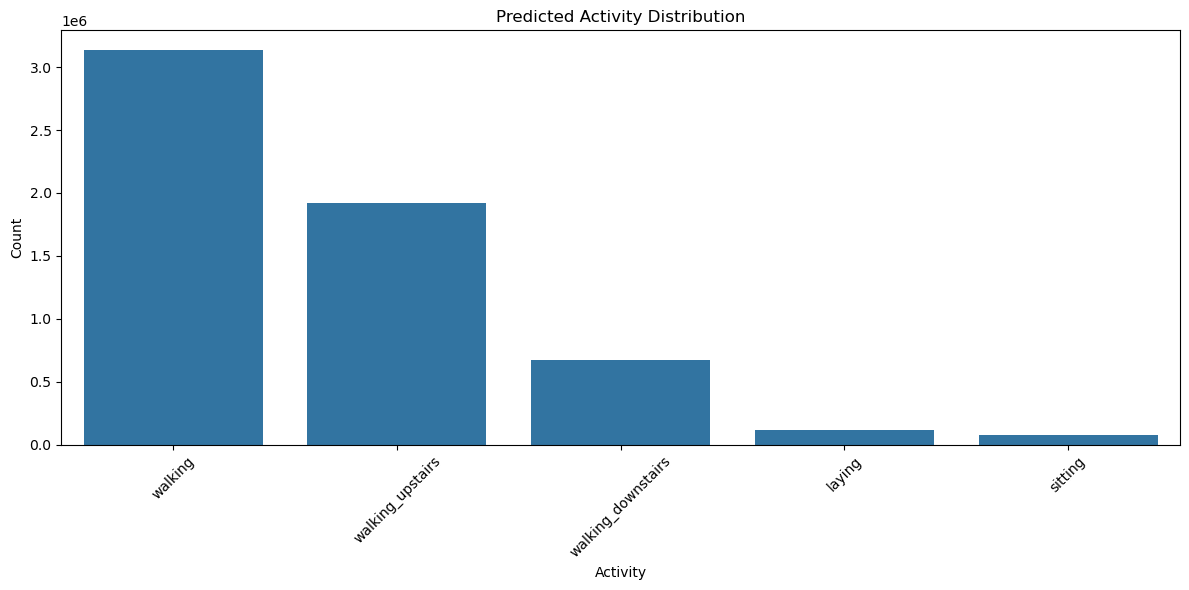

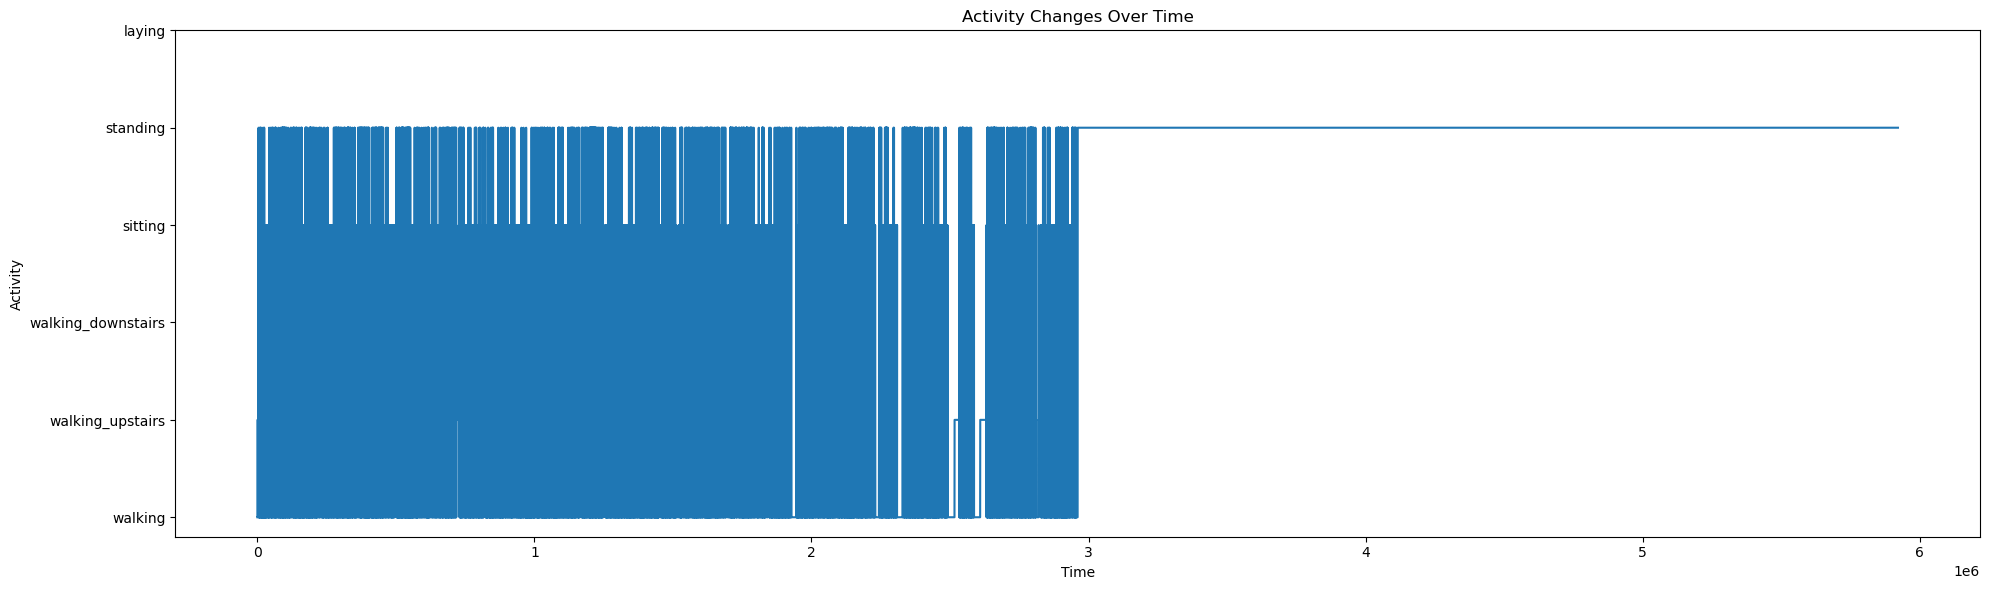

예측 완료 및 결과 저장됨


In [10]:
# 학습된 모델 로드
for i, model in enumerate(models):
    checkpoint = torch.load(f'best_model_{i+1}.pth.tar')
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

# 자이로 데이터를 GPU로 이동
gyro_data_tensor = gyro_data_tensor.to(device)

print(f"gyro_data_tensor shape: {gyro_data_tensor.shape}")

# 예측
batch_size = 100
all_predictions = []

for i in range(0, len(gyro_data_tensor), batch_size):
    batch = gyro_data_tensor[i:i+batch_size]
    # 마지막 배치 처리
    if len(batch) < batch_size:
        padding = torch.zeros(batch_size - len(batch), *batch.shape[1:], device=device)
        batch = torch.cat([batch, padding], dim=0)
    batch_predictions = ensemble_predict(models, batch)
    # 패딩 제거
    all_predictions.append(batch_predictions[:len(gyro_data_tensor[i:i+batch_size])])

all_predictions = torch.cat(all_predictions).cpu().numpy()

# 슬라이딩 윈도우 예측 결과를 원본 데이터에 매핑하는 함수
def map_predictions_to_original(original_data_length, predictions, window_size, stride):
    mapped_predictions = np.zeros((original_data_length, 6))  # 6은 활동 클래스의 수
    counts = np.zeros(original_data_length)
    
    for i, pred in enumerate(predictions):
        start = i * stride
        end = min(start + window_size, original_data_length)
        mapped_predictions[start:end, pred] += 1
        counts[start:end] += 1
    
    # 각 데이터 포인트에 대해 가장 많이 예측된 라벨 선택
    final_predictions = np.argmax(mapped_predictions, axis=1)
    
    return final_predictions

# 원본 자이로 데이터 로드
original_gyro_data = pd.read_csv('./원본 데이터/자이로 데이터.csv')

# 원본 데이터에 맞는 예측 라벨 생성
original_predictions = map_predictions_to_original(len(original_gyro_data), all_predictions, window_size=128, stride=64)

# 예측된 라벨을 활동 이름으로 매핑
activity_labels = {0: "walking", 1: "walking_upstairs", 2: "walking_downstairs", 3: "sitting", 4: "standing", 5: "laying"}
predicted_activities = [activity_labels[label] for label in original_predictions]

# 예측 결과 출력
for i, activity in enumerate(predicted_activities[:10]):
    print(f"Sample {i}: {activity}")

# 자이로 데이터에 예측 결과 추가
original_gyro_data['Predicted_Activity'] = predicted_activities

# 결과 저장
original_gyro_data.to_csv('./원본 데이터/자이로 데이터_예측.csv', index=False)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
activity_counts = pd.Series(predicted_activities).value_counts()
sns.barplot(x=activity_counts.index, y=activity_counts.values)
plt.title('Predicted Activity Distribution')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 시간에 따른 활동 변화 시각화
plt.figure(figsize=(20, 6))
activity_series = pd.Series(predicted_activities)
activity_numeric = pd.factorize(activity_series)[0]
plt.plot(activity_numeric)
plt.title('Activity Changes Over Time')
plt.xlabel('Time')
plt.ylabel('Activity')
plt.yticks(range(len(activity_labels)), list(activity_labels.values()))
plt.tight_layout()
plt.show()

print("예측 완료 및 결과 저장됨")

## 9. 성능 평가 및 시각화

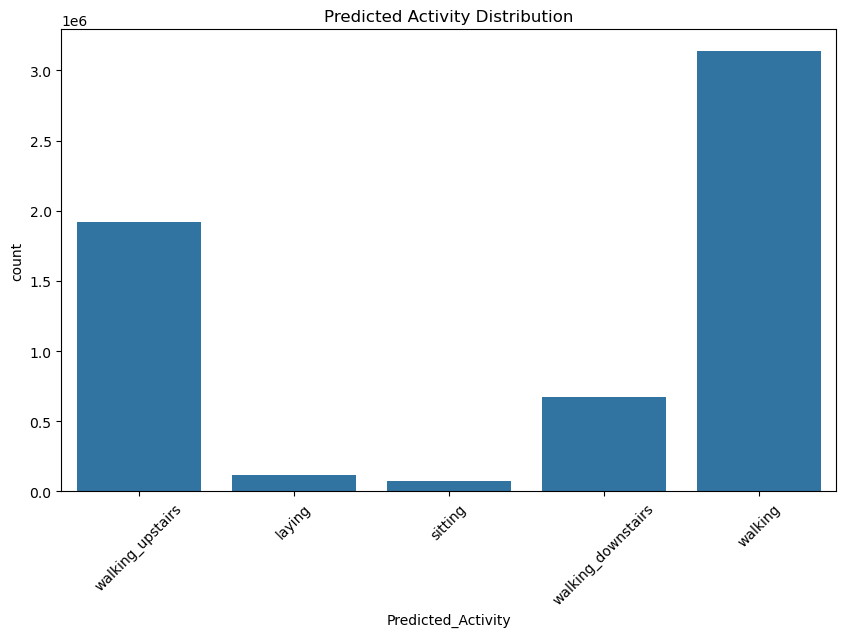

Predicted_Activity
walking               0.529614
walking_upstairs      0.324097
walking_downstairs    0.114122
laying                0.019316
sitting               0.012852
Name: proportion, dtype: float64
K-Means Clustering Accuracy: 0.09


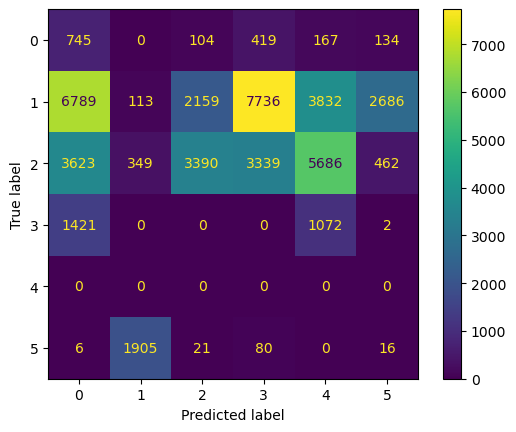

              precision    recall  f1-score   support

           0       0.06      0.47      0.11      1569
           1       0.05      0.00      0.01     23315
           2       0.60      0.20      0.30     16849
           3       0.00      0.00      0.00      2495
           4       0.00      0.00      0.00         0
           5       0.00      0.01      0.01      2028

    accuracy                           0.09     46256
   macro avg       0.12      0.11      0.07     46256
weighted avg       0.24      0.09      0.12     46256



C:\Users\user\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\anaconda3\envs\ai\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# 자이로 데이터에 라벨 추가
gyro_data = pd.read_csv('./원본 데이터/자이로 데이터.csv')
gyro_data['Predicted_Activity'] = predicted_activities[:len(gyro_data)]  # 길이 맞춤

# 라벨링된 자이로 데이터를 저장
gyro_data.to_csv('./원본 데이터/자이로 데이터_예측.csv', index=False)

# 예측된 활동별 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(x=gyro_data['Predicted_Activity'])
plt.title('Predicted Activity Distribution')
plt.xticks(rotation=45)
plt.show()

# 예측 결과 요약
print(gyro_data['Predicted_Activity'].value_counts(normalize=True))

# 클러스터링 적용 및 결과 비교
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels = kmeans.fit_predict(gyro_data_tensor.cpu().numpy().reshape(gyro_data_tensor.shape[0], -1))

# 클러스터링 결과와 실제 예측 라벨 비교
kmeans_accuracy = accuracy_score(all_predictions, kmeans_labels)
print(f"K-Means Clustering Accuracy: {kmeans_accuracy:.2f}")

# Confusion Matrix 및 성능 평가
cm = confusion_matrix(all_predictions, kmeans_labels)
ConfusionMatrixDisplay(cm).plot()
plt.show()

print(classification_report(all_predictions, kmeans_labels))